In [69]:
%matplotlib inline
import datetime
import cPickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from consts import df_sec_res_pk

In [2]:
with open(df_sec_res_pk, 'r') as f:
    df_res = cPickle.load(f)

In [3]:
df_res.head()

sec_code     period  chg_stk_mean  chg_stk_std  chg_sec  stk_inc_mean  \
0  400129776 2015-12-15      1.735622     1.924204   2.4363      0.923077   
1  400129776 2015-12-16      1.203826     2.518869   0.2556      0.692308   
2  400129776 2015-12-17      1.835144     2.473024   0.8155      0.810127   
3  400129776 2015-12-18     -1.026785     2.432026  -0.5593      0.243590   
4  400129776 2015-12-21     -2.386111     2.026529  -2.6545      0.075949   

   stk_inc_sum  stk_inc_size   chg_std  
0           72            78  0.964054  
1           54            78  0.964054  
2           64            79  0.964054  
3           19            78  0.964054  
4            6            79  0.964054

In [5]:
df_res.query('chg_sec > chg_std & stk_inc_mean > 0.5').shape

(33, 9)

* 一共有33天（33/305）符合上涨的条件

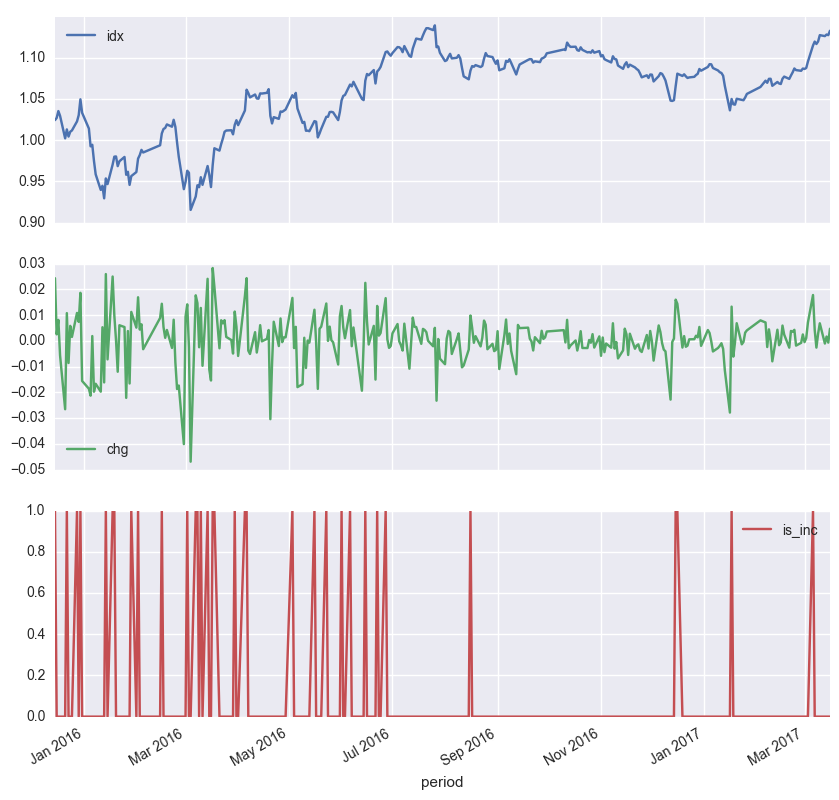

In [23]:
plots = df_res.assign(
    is_inc = lambda df: (df['stk_inc_mean'] >= 0.5)\
        & (df['chg_sec'] > df['chg_std']).astype(int))\
    .assign(chg = lambda df: df['chg_sec'] / 100.0)\
    .assign(prod_base = lambda df: df['chg'] + 1)\
    .assign(idx = lambda df: df.prod_base.cumprod())\
    .loc[:, ['period', 'idx', 'chg', 'is_inc']]\
    .set_index('period')\
    .plot(subplots=True, figsize=(10, 10))
plt.show()

## 1. 规则说明
* 上涨周期的起始点：一个明确的持有信号（一个标准差和50%上涨，前一个条件完全覆盖后一个条件）
* 上涨周期的结束：指数下跌
* 累计压栈的天数是否构成上涨：累计涨幅超过三个标准差

In [27]:
df_res.describe().T

count          mean           std           min           25%  \
sec_code      305.0  4.001298e+08  0.000000e+00  4.001298e+08  4.001298e+08   
chg_stk_mean  305.0  8.935090e-03  1.389117e+00 -6.537325e+00 -4.890094e-01   
chg_stk_std   305.0  2.022618e+00  5.730286e-01  5.436166e-01  1.592156e+00   
chg_sec       305.0  4.556820e-02  9.640536e-01 -4.692600e+00 -2.865000e-01   
stk_inc_mean  305.0  4.795372e-01  2.397663e-01  1.136364e-02  3.039216e-01   
stk_inc_sum   305.0  4.513443e+01  2.222800e+01  1.000000e+00  3.000000e+01   
stk_inc_size  305.0  9.432787e+01  5.330897e+00  7.800000e+01  8.900000e+01   
chg_std       305.0  9.640536e-01  2.891324e-15  9.640536e-01  9.640536e-01   

                       50%           75%           max  
sec_code      4.001298e+08  4.001298e+08  4.001298e+08  
chg_stk_mean  1.406968e-01  6.294980e-01  4.035291e+00  
chg_stk_std   1.936737e+00  2.369710e+00  4.180837e+00  
chg_sec       7.490000e-02  5.249000e-01  2.832400e+00  
stk_inc_mean  4.693878e-01  6.494845e-01  1.000000e+00  
stk_inc_sum   4.600000e+01  6.100000e+01  9.600000e+01  
stk_inc_size  9.600000e+01  9.800000e+01  1.020000e+02  
chg_std       9.640536e-01  9.640536e-01  9.640536e-01

## 2. 计算相关阈值变量
* 是否上涨，<font color='red'>目前使用涨幅超过一个标准差，且上涨股票数超过68%</font>
* 是否下跌（否定部分则为可压栈），<font color='red'>目前使用指数下降，感觉略宽松</font>
* 是否持续上涨（替代判断是否可以压栈的办法），<font color='red'>超过68%的个股上涨，且指数上涨</font>
* 指数（用于计算累计涨幅）

> 
#### 可调整的规则和超变量
* 是否启动涨幅：涨幅超过一个标准差，理论上应该允许回看过去一天或两天是否有一个启动
* 涨幅停止的信号
* 涨幅的一个标准差
* 68%的个股上涨

In [112]:
df_marked_res = df_res\
    .assign(is_inc = lambda df: (df['stk_inc_mean'] > 0.68)
            & (df['chg_sec'] > df['chg_std']))\
    .assign(chg = lambda df: df['chg_sec'] / 100.0)\
    .assign(prod_base = lambda df: df['chg'] + 1)\
    .assign(idx = lambda df: df.prod_base.cumprod())\
    .assign(is_desc = lambda df: df['chg_sec'] < 0)\
    .assign(is_cont = lambda df: df['stk_inc_mean'] > 0.68)\
    .set_index('period')

In [113]:
df_marked_res.head()

sec_code  chg_stk_mean  chg_stk_std  chg_sec  stk_inc_mean  \
period                                                                    
2015-12-15  400129776      1.735622     1.924204   2.4363      0.923077   
2015-12-16  400129776      1.203826     2.518869   0.2556      0.692308   
2015-12-17  400129776      1.835144     2.473024   0.8155      0.810127   
2015-12-18  400129776     -1.026785     2.432026  -0.5593      0.243590   
2015-12-21  400129776     -2.386111     2.026529  -2.6545      0.075949   

            stk_inc_sum  stk_inc_size   chg_std is_inc       chg  prod_base  \
period                                                                        
2015-12-15           72            78  0.964054   True  0.024363   1.024363   
2015-12-16           54            78  0.964054  False  0.002556   1.002556   
2015-12-17           64            79  0.964054  False  0.008155   1.008155   
2015-12-18           19            78  0.964054  False -0.005593   0.994407   
2015-12-21            6            79  0.964054  False -0.026545   0.973455   

                 idx is_desc is_cont  
period                                
2015-12-15  1.024363   False    True  
2015-12-16  1.026981   False    True  
2015-12-17  1.035356   False    True  
2015-12-18  1.029566    True   False  
2015-12-21  1.002236    True   False

In [116]:
# periods result containers
res_periods = []
last_period, last_item = None, pd.Series()
temp_periods = []
for period, item in df_marked_res.iterrows():
    # deal with raise period
    if item.get('is_inc', False):
        if temp_periods:
            temp_periods.append(period)
        # if start raise, check whether last period is continue
        elif last_item.get('is_cont', False):
            temp_periods.extend([last_period, period])
        else:
            temp_periods.append(period)
    # deal with continous raise period
    elif item.get('is_cont', False):
        if temp_periods:
            temp_periods.append(period)
    # deal with decrease period
    elif item.get('is_desc', False):
        # if temp periods hold data, check whether its raising percent is appreciate
        if temp_periods:
            if len(temp_periods) == 1 and last_item.get('chg_sec', -99) > 2:
                res_periods.append([last_period, last_period, last_item['chg_sec']])
            else:
                start_dt, end_dt = temp_periods[0], temp_periods[-1]
                # start index store in the day before
                try:
                    start_idx = df_marked_res\
                        .at[(start_dt - pd.Timedelta('1 days')), 'idx']
                except KeyError:
                    start_idx = 1
                end_idx = df_marked_res.at[end_dt, 'idx']
                raise_pct = (end_idx * 1.0 / start_idx - 1)
                if raise_pct > 0.02:
                    res_periods.append([start_dt, end_dt, raise_pct * 100])
            # if holds temp_periods in decreasing part, clear it.
            temp_periods = []
    # assign current period and item to last at the end
    last_period, last_item = period, item

In [117]:
pd.DataFrame(res_periods, columns=['start', 'end', 'cum_inc'])

start        end    cum_inc
0  2015-12-15 2015-12-17   3.535630
1  2016-01-14 2016-01-14   2.596800
2  2016-01-29 2016-02-04   4.496177
3  2016-03-01 2016-03-02   2.375170
4  2016-03-14 2016-03-14   2.413000
5  2016-03-17 2016-03-18   4.996405
6  2016-04-05 2016-04-06   6.128815
7  2016-05-03 2016-05-03   5.458546
8  2016-05-16 2016-05-16   2.313889
9  2016-05-20 2016-05-23   2.013320
10 2016-05-31 2016-06-06   4.209637
11 2016-06-15 2016-06-15   2.255700
12 2016-06-22 2016-06-27   3.571920
13 2016-12-15 2016-12-16   3.070351
14 2017-03-06 2017-03-06  11.496907